In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithMeans (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithMeans.fit(self, trainset_fold)
            train_prediction = KNNWithMeans.test(self, trainset_fold.build_testset())
            prediction = KNNWithMeans.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithMeans.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithMeans SGD

* knn_with_means cosine, user based

In [4]:
knn_with_means = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means.create_reader(data)
predictions = knn_with_means.fit()
#acc
metrics = knn_with_means.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5086
RMSE: 1.5563
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.4930
RMSE: 1.5162
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5379
RMSE: 1.3396
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5316
RMSE: 1.4079
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5474
RMSE: 1.3181
###############################################
The Results are: 

Average RMSE on Training Set: 0.5236970466536481
Average RMSE on Test Set: 1.4276066341125735
RMSE: 1.4071
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4071112401635857
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4071
MAE:  1.0896
MSE: 1.9800
Precision: 0.06
Recall: 0.04
the acc is 32.46


/tmp/ipykernel_18077/655597585.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_means cosine, item based

In [5]:
knn_with_means2 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means2.create_reader(data)
predictions = knn_with_means2.fit()
#acc
metrics = knn_with_means2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5562
RMSE: 1.6603
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5289
RMSE: 1.6993
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5682
RMSE: 1.5800
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6232
RMSE: 1.3151
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5672
RMSE: 1.6187
###############################################
The Results are: 

Average RMSE on Training Set: 0.5687542564563975
Average RMSE on Test Set: 1.5746676803026367
RMSE: 1.6395
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.6395244933353583
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.6395
MAE:  1.2815
MSE: 2.6880
Precision: 0.06
Recall: 0.03
the acc is 25.13


/tmp/ipykernel_18077/3877873262.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/3877873262.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared difference, user based

In [6]:
knn_with_means3 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means3.create_reader(data)
predictions = knn_with_means3.fit()
#acc
metrics = knn_with_means3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3286
RMSE: 1.3467
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2890
RMSE: 1.4039
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3219
RMSE: 1.3018
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3252
RMSE: 1.4970
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2722
RMSE: 1.4166
###############################################
The Results are: 

Average RMSE on Training Set: 0.30738765104106525
Average RMSE on Test Set: 1.3932082655771314
RMSE: 1.4198
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4198388885717397
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4198
MAE:  1.0484
MSE: 2.0159
Precision: 0.05
Recall: 0.05
the acc is 34.03


/tmp/ipykernel_18077/289524525.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/289524525.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared diference, item based

In [7]:
knn_with_means4 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means4.create_reader(data)
predictions = knn_with_means4.fit()
#acc
metrics = knn_with_means4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3997
RMSE: 1.5581
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4190
RMSE: 1.6587
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4291
RMSE: 1.6169
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4274
RMSE: 1.6011
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4362
RMSE: 1.4892
###############################################
The Results are: 

Average RMSE on Training Set: 0.422288223382572
Average RMSE on Test Set: 1.5847993498539106
RMSE: 1.4542
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4541940328697633
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4542
MAE:  1.1337
MSE: 2.1147
Precision: 0.04
Recall: 0.02
the acc is 28.27


/tmp/ipykernel_18077/2026458134.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/2026458134.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, user based

In [8]:
knn_with_means5 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means5.create_reader(data)
predictions = knn_with_means5.fit()
#acc
metrics = knn_with_means5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1492
RMSE: 1.4298
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1198
RMSE: 1.3866
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1819
RMSE: 1.5363
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1176
RMSE: 1.3958
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1666
RMSE: 1.4123
###############################################
The Results are: 

Average RMSE on Training Set: 0.14699940862929878
Average RMSE on Test Set: 1.4321764771005152
RMSE: 1.4589
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4588810505414822
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4589
MAE:  1.1225
MSE: 2.1283
Precision: 0.07
Recall: 0.08
the acc is 29.32


/tmp/ipykernel_18077/2000926961.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/2000926961.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_means6 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means6.create_reader(data)
predictions = knn_with_means6.fit()
#acc
metrics = knn_with_means6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0746
RMSE: 1.6775
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1536
RMSE: 1.5047
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1643
RMSE: 1.5106
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0957
RMSE: 1.6364
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1740
RMSE: 1.4742
###############################################
The Results are: 

Average RMSE on Training Set: 0.13242229355659568
Average RMSE on Test Set: 1.5606864395216649
RMSE: 1.6672
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.6671557675977633
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.6672
MAE:  1.2911
MSE: 2.7794
Precision: 0.06
Recall: 0.04
the acc is 27.23


/tmp/ipykernel_18077/1753961335.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/1753961335.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_means7 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means7.create_reader(data)
predictions = knn_with_means7.fit()
#acc
metrics = knn_with_means7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1384
RMSE: 1.3755
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1442
RMSE: 1.3514
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1469
RMSE: 1.3907
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0812
RMSE: 1.5738
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1006
RMSE: 1.4060
###############################################
The Results are: 

Average RMSE on Training Set: 0.12226375928818833
Average RMSE on Test Set: 1.419501742760802
RMSE: 1.3605
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3605347258021323
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18077/101808052.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/101808052.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_means8 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means8.create_reader(data)
predictions = knn_with_means8.fit()
#acc
metrics = knn_with_means8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1033
RMSE: 1.4723
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1106
RMSE: 1.5257
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0843
RMSE: 1.6648
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1144
RMSE: 1.5737
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0981
RMSE: 1.4999
###############################################
The Results are: 

Average RMSE on Training Set: 0.10214597767944626
Average RMSE on Test Set: 1.5473026394621943
RMSE: 1.5583
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5582514677234998
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18077/1437423512.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/1437423512.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans Alternating Least Squares (ALS)

* KnnWithMeans cosine, user based

In [12]:
knn_with_means9 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means9.create_reader(data)
predictions = knn_with_means9.fit()
#acc
metrics = knn_with_means9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5245
RMSE: 1.4041
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5446
RMSE: 1.3406
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5525
RMSE: 1.4578
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5182
RMSE: 1.4303
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5197
RMSE: 1.3953
###############################################
The Results are: 

Average RMSE on Training Set: 0.5319021041503296
Average RMSE on Test Set: 1.4056038842970544
RMSE: 1.4057
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4057157294438452
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.4057
MAE:  1.0848
MSE: 1.9760
Precision: 0.08
Recall: 0.06
the acc is 32.46


/tmp/ipykernel_18077/1812438443.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/1812438443.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans cosine, item based

In [13]:
knn_with_means10 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means10.create_reader(data)
predictions = knn_with_means10.fit()
#acc
metrics = knn_with_means10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5415
RMSE: 1.6414
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6409
RMSE: 1.3214
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5551
RMSE: 1.6451
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5546
RMSE: 1.7190
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5738
RMSE: 1.6301
###############################################
The Results are: 

Average RMSE on Training Set: 0.5731680052713772
Average RMSE on Test Set: 1.591425960573937
RMSE: 1.5702
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5701849703784776
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5702
MAE:  1.1545
MSE: 2.4655
Precision: 0.09
Recall: 0.08
the acc is 33.51


/tmp/ipykernel_18077/3298270025.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/3298270025.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeansWithMeans mean squared difference, user based

In [14]:
knn_with_means11 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means11.create_reader(data)
predictions = knn_with_means11.fit()
#acc
metrics = knn_with_means11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2747
RMSE: 1.3455
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2917
RMSE: 1.5745
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3043
RMSE: 1.3884
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2978
RMSE: 1.5574
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3069
RMSE: 1.4553
###############################################
The Results are: 

Average RMSE on Training Set: 0.2950775359104267
Average RMSE on Test Set: 1.464213975159319
RMSE: 1.4086
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4086039993315354
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.4086
MAE:  1.1100
MSE: 1.9842
Precision: 0.06
Recall: 0.04
the acc is 29.84


/tmp/ipykernel_18077/4069916643.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/4069916643.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeans mean squared difference, item based

In [15]:
knn_with_means12 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means12.create_reader(data)
predictions = knn_with_means12.fit()
#acc
metrics = knn_with_means12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4140
RMSE: 1.6292
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4197
RMSE: 1.5864
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4073
RMSE: 1.5471
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4214
RMSE: 1.5889
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4216
RMSE: 1.5019
###############################################
The Results are: 

Average RMSE on Training Set: 0.41680823961348495
Average RMSE on Test Set: 1.57069742605674
RMSE: 1.5670
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5670386708222148
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5670
MAE:  1.1820
MSE: 2.4556
Precision: 0.09
Recall: 0.06
the acc is 29.32


/tmp/ipykernel_18077/3923251051.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/3923251051.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, user based

In [16]:
knn_with_means13 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means13.create_reader(data)
predictions = knn_with_means13.fit()
#acc
metrics = knn_with_means13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1826
RMSE: 1.4887
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1279
RMSE: 1.4630
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1484
RMSE: 1.3881
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0846
RMSE: 1.3956
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1770
RMSE: 1.4635
###############################################
The Results are: 

Average RMSE on Training Set: 0.14411057476410513
Average RMSE on Test Set: 1.4397592279037894
RMSE: 1.3891
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.389114808650005
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3891
MAE:  1.0402
MSE: 1.9296
Precision: 0.07
Recall: 0.05
the acc is 37.17


/tmp/ipykernel_18077/3977358235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/3977358235.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, item based

In [17]:
knn_with_means14 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means14.create_reader(data)
predictions = knn_with_means14.fit()
#acc
metrics = knn_with_means14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0934
RMSE: 1.5365
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0892
RMSE: 1.4974
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0973
RMSE: 1.6215
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0924
RMSE: 1.4986
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1118
RMSE: 1.6399
###############################################
The Results are: 

Average RMSE on Training Set: 0.09682033703545505
Average RMSE on Test Set: 1.5587800416406417
RMSE: 1.5728
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.572805661591812
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5728
MAE:  1.2033
MSE: 2.4737
Precision: 0.03
Recall: 0.02
the acc is 32.46


/tmp/ipykernel_18077/2985716342.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/2985716342.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_means15 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means15.create_reader(data)
predictions = knn_with_means15.fit()
#acc
metrics = knn_with_means15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1090
RMSE: 1.2685
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1022
RMSE: 1.3666
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0832
RMSE: 1.4334
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1062
RMSE: 1.4992
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1123
RMSE: 1.4849
###############################################
The Results are: 

Average RMSE on Training Set: 0.10256808296832558
Average RMSE on Test Set: 1.41052043347324
RMSE: 1.4197
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.419747520230169
Computing the pearson_baseline similarity matrix...

/tmp/ipykernel_18077/1732976370.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/1732976370.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_means16 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means16.create_reader(data)
predictions = knn_with_means16.fit()
#acc
metrics = knn_with_means16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1371
RMSE: 1.5552
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1350
RMSE: 1.6142
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1454
RMSE: 1.6609
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0896
RMSE: 1.5195
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0994
RMSE: 1.6426
###############################################
The Results are: 

Average RMSE on Training Set: 0.12130806063799782
Average RMSE on Test Set: 1.598479005482536
RMSE: 1.4397
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4396997396162114
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18077/3559677741.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18077/3559677741.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
6,7,KnnWithMeans,(shrunk) pearson corr coeff,SGD,True,1.360535,1.027097,1.851055,0.057207,0.060565,32.460733
12,13,KnnWithMeans,pearson corr coeff,ALS,True,1.389115,1.040231,1.929640,0.070513,0.047009,37.172775
8,9,KnnWithMeans,Cosine,ALS,True,1.405716,1.084766,1.976037,0.079545,0.063492,32.460733
0,1,KnnWithMeans,Cosine,SGD,True,1.407111,1.089637,1.979962,0.063158,0.043710,32.460733
10,11,KnnWithMeans,MSD,ALS,True,1.408604,1.110031,1.984165,0.062500,0.038368,29.842932
14,15,KnnWithMeans,(shrunk) pearson corr coeff,ALS,True,1.419748,1.059466,2.015683,0.054878,0.031504,34.031414
2,3,KnnWithMeans,MSD,SGD,True,1.419839,1.048381,2.015942,0.054902,0.049412,34.031414
15,16,KnnWithMeans,(shrunk) pearson corr coeff,ALS,False,1.439700,1.050467,2.072735,0.123457,0.102357,35.602094
3,4,KnnWithMeans,MSD,SGD,False,1.454194,1.133715,2.114680,0.040230,0.023755,28.272251
4,5,KnnWithMeans,pearson corr coeff,SGD,True,1.458881,1.122542,2.128334,0.070736,0.075789,29.319372


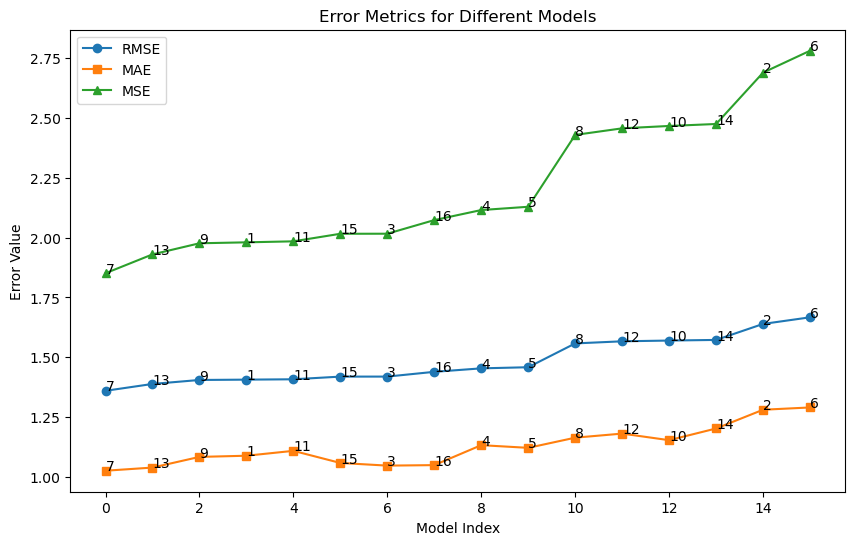

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

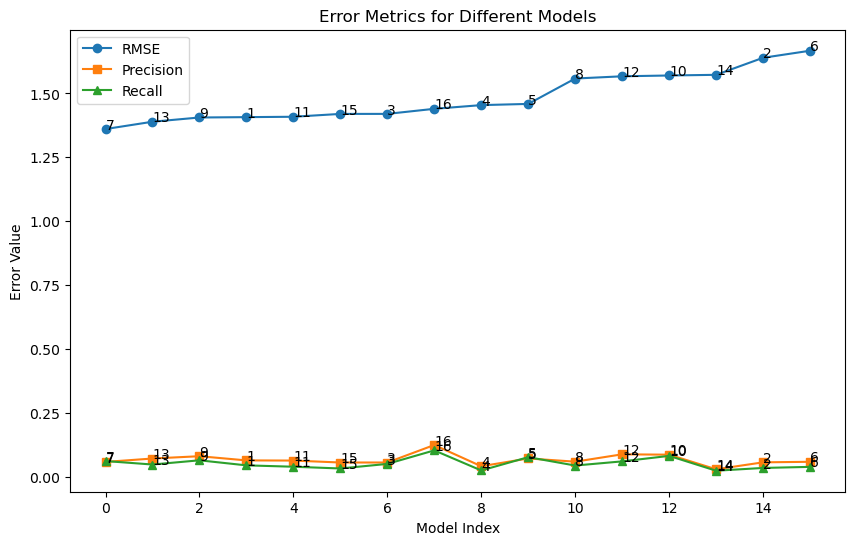

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

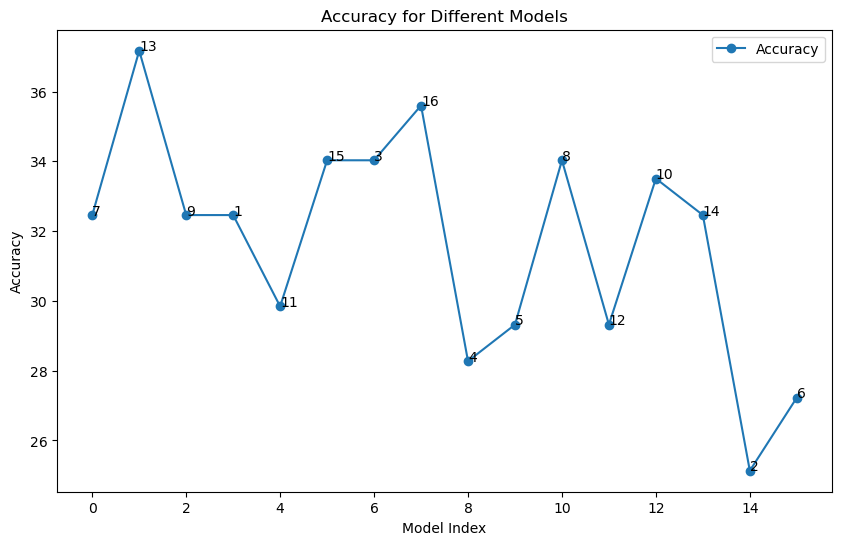

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_means.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Cirus Madiran
2. Item ID: Marlborough
3. Item ID: Pinot gris
4. Item ID: Pinot blanc


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_means.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5
2. User ID: d48fd3bd-06e9-4368-97b9-aae545388325
3. User ID: 518f9753-12b1-4987-b651-38944fc33d07


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_means.get_neighbors_uid(user_id=5)

['dd7e04c1-987c-4520-9ab5-c90e86b7dfe1',
 'f146626e-7c67-46a5-8226-79df4a9b8294',
 '09f6ca6e-905f-4afd-bab2-d928fe046f18',
 'c2dfb861-cdad-4fb2-9460-fc794c7f6cad',
 '367d109c-cc13-43ec-b153-a9547a12bd4c',
 '71d38b96-326c-4d01-afc4-b12c947a5c6b',
 '0c0fb748-ee39-4687-b1a4-65044a48a02f',
 '36b67621-8e5f-42db-ba2c-43a3eb2855cc',
 '0a23a07a-8556-4ef6-85ee-d996f8ed619e',
 'cabb87a0-6498-438a-beb7-676f72bddd09']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_means.get_neighbors_iid(item_id=20)

['Clos la Laterne',
 'Jesera Pinot Grigio',
 'Zamò Bianco',
 'Klein St cabernet sauvignon',
 'Chianti Classico',
 'Sauvignon',
 'Trento Brut',
 'Quid Pro Quo - tinto red blend',
 'Mendoza Pinot Grigio',
 'Casillero del diablo pinot gringo']

In [28]:
knn_with_means.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_means.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 16 with sim 0.000000000000000
user 58 with sim 0.000000000000000
And the baseline estimate is: 2.8676698375158156

#####

Note: If the baseline is 2.8852459016393444 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_means.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Jurançon Sec,3.0,2.947541,"{'was_impossible': True, 'reason': 'User and/o...",78,1,0.052459
1,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Sauvignon,4.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",8,2,3.000000
2,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Klein St cabernet sauvignon,4.0,2.947541,"{'was_impossible': True, 'reason': 'User and/o...",21,1,1.052459
3,e336887b-883b-4d9a-8cd3-060c25856bfb,Tenuta Sant'Helena Pinot Grigio,3.0,2.947541,"{'was_impossible': True, 'reason': 'User and/o...",4,1,0.052459
4,70c67292-57ce-4012-a939-5e6ddcb499f8,Nero d'Avola Sicilia,3.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",3,1,2.000000
5,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",14,2,0.000000
6,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bolgheri+,2.0,2.947541,"{'was_impossible': True, 'reason': 'User and/o...",78,1,0.947541
7,2a62eecd-b0cd-4395-9f8c-7c912a208be2,The long coast cabernet sauvignon,4.0,2.947541,"{'was_impossible': True, 'reason': 'User and/o...",21,1,1.052459
8,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Nativi Gewürtztraminer,1.0,1.006869,"{'actual_k': 2, 'was_impossible': False}",35,5,0.006869
9,71d38b96-326c-4d01-afc4-b12c947a5c6b,Pinot Gris,1.0,2.000000,"{'actual_k': 0, 'was_impossible': False}",6,3,1.000000


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
95,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Cerasuolo di Vittoria,3.0,3.0,"{'actual_k': 20, 'was_impossible': False}",78,1,0.0
127,5ccd8030-047b-432c-a630-d784ab415756,Dettelbach Silvaner,3.0,3.0,"{'actual_k': 3, 'was_impossible': False}",47,2,0.0
124,25a04c51-5638-42f0-b2e7-ce49b1c280fc,Morellino di Scansano 2021,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",3,7,0.0
123,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pojega,3.0,3.0,"{'actual_k': 20, 'was_impossible': False}",78,0,0.0
52,8a5ddd23-7ed8-4ac0-9c5d-12ff3b908053,Monterey Pinot Noir,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",3,1,0.0
27,13016d41-00bd-411c-83f5-2b95691696b7,Vitovska acciaio,4.0,4.0,"{'actual_k': 1, 'was_impossible': False}",7,7,0.0
112,2ae69fac-d491-412f-8164-ccaf59a230c2,Morellino di Scansano 2021,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",4,7,0.0
109,defee34b-7775-4889-b703-92b730d85e70,Montepulciano 60,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",6,2,0.0
107,776b5af7-bb8a-484a-bddb-dadf5dab4621,Zahorra Blanca,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",3,1,0.0
189,e019e935-677a-4713-9c68-e19d2db878c4,Zinfandel,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",4,4,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
165,a3b393ad-38d5-4c5a-b814-5fec18a1fa9d,Traluna Toscana,1.0,4.0,"{'actual_k': 0, 'was_impossible': False}",4,1,3.0
133,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Nebbiolo d'Alba DOC Spumante Cuvée 970 Brut Rosé,4.0,1.0,"{'actual_k': 0, 'was_impossible': False}",35,2,3.0
134,776b5af7-bb8a-484a-bddb-dadf5dab4621,Weissburgunder Kallstadter Steinacker,1.0,4.0,"{'actual_k': 0, 'was_impossible': False}",3,2,3.0
136,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Perlugo Extra Brut,4.0,1.0,"{'actual_k': 0, 'was_impossible': False}",35,2,3.0
19,014e4ed1-6f8b-4b25-917d-c167a2acca17,New Wine,1.0,4.0,"{'actual_k': 0, 'was_impossible': False}",3,1,3.0
80,defee34b-7775-4889-b703-92b730d85e70,Terrarosa,4.0,1.0,"{'actual_k': 0, 'was_impossible': False}",6,1,3.0
171,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Organic pinot grigio terre siciliane igt,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",21,1,4.0
70,22c5c1cb-88fd-4870-a911-846516978ed4,Malbec (High Mountain Vines),5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",1,0,4.0
154,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Casillero del diabolo merlot Chile,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",21,1,4.0
108,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Vieilles Vignes Rouge,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",35,1,4.0
